In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

67 sessions!
67 sessions!


In [2]:
import cluster_analysis as ca
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import map_switching_analysis as msa
import cluster_plot as cp

In [339]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e16_3m2_211213"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load=dict(filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [4]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [5]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [6]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [484]:
%%time
reload(msa)
task_ind,tt_ind =0,0
n_fac=3
spk_beh_df_sub=spk_beh_df.loc[spk_beh_df['trial_type']==(task_ind,tt_ind)]
fitted_mean_d, clust_label_original = msa.cluster_population_vector_all_posbin(spk_beh_df_sub,cell_cols,smth_kws={},n_clust = n_fac,bin_size=None,speed_key='v',speed_thresh=1.,do_norm=True)




CPU times: user 3min 32s, sys: 59.8 s, total: 4min 31s
Wall time: 1min 11s


In [485]:
%%time
reload(msa)
multiple_maps, clust_label_new_combined,fitted_mean_d_new, clust_label_new,noflip = msa.align_maps(fitted_mean_d, clust_label_original,neuron_uid=cell_cols)



CPU times: user 138 ms, sys: 102 ms, total: 240 ms
Wall time: 62.2 ms


In [146]:
# clust_label_new_combined = clust_label_new_combined.sort_index()

In [486]:
map_switch = clust_label_new_combined['label'].diff().dropna(axis=0)!=0
clust_label_new_combined.loc[map_switch.index,'map_switch'] = map_switch

In [511]:
msa.align_two_means(fitted_mean_d_new[46],fitted_mean_d_new[47])

(array([0, 1, 1]), False)

In [542]:
mean_1 = fitted_mean_d[2]
mean_2 = fitted_mean_d[3]

In [545]:
n_fac = mean_1.shape[0]
corr = np.corrcoef(mean_1,mean_2)
corr = corr[n_fac:,:n_fac]

# corr_prop = corr / corr.sum(axis=1,keepdims=True) # ignore negative case for now; proportion of similarity of mean_2 (row) to each mean_1 factor (col)

# ind_map_for_2 = np.argmax(corr_prop,axis=0) #compre proportion across mean_2 (row), even if it's not the highest proportion within mean_2, if by proportion bigger than the rest, assign that factor to the corresponding col   # ind_map_for_2[i]: "correct" label for the original label i

In [546]:
corr

array([[0.29254026, 0.4303395 , 0.18526834],
       [0.82966869, 0.74705027, 0.83363851],
       [0.45895114, 0.84814956, 0.56523026]])

In [544]:
corr_prop

array([[0.32212837, 0.47386489, 0.20400674],
       [0.34420981, 0.30993339, 0.34585679],
       [0.24512287, 0.45299126, 0.30188587]])

In [537]:
np.isclose(fitted_mean_d_new[2][1],fitted_mean_d_new[2][2])

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True,  True, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False,

In [487]:
clust_label_new_combined.rolling(roll_win).mean()

,lin_binned,label,map_switch
Time (s),,,
7890.001933,NaN,NaN,NaN
7890.035267,NaN,NaN,NaN
7890.068600,3.000000,0.000000,NaN
7890.101967,3.000000,0.000000,0.000000
7890.135300,3.000000,0.000000,0.000000
...,...,...,...
9970.660800,87.000000,0.000000,0.000000
9970.694133,87.000000,0.000000,0.000000
9974.028300,87.333333,0.666667,0.333333


<AxesSubplot:xlabel='lin_binned', ylabel='map_switch'>

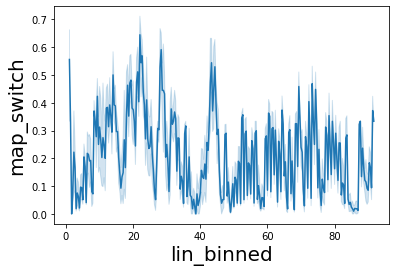

In [488]:
%matplotlib inline
roll_win = 3
clust_label_new_combined_roll = clust_label_new_combined.rolling(roll_win).mean().dropna(axis=0)
sns.lineplot(data=clust_label_new_combined_roll,x='lin_binned',y='map_switch')

In [489]:
import cluster_analysis as ca
map_tuning = ca.get_cluster_tuning(multiple_maps.sum(axis=1).unstack().T)

tuning_argmax=map_tuning[['tuning_0','tuning_1']].values.argmax(axis=1)

# n_fac = 2
ind_belong_each_map = {}
ind_sorted_combined = []
for fac in range(n_fac):
    ind = map_tuning.index[np.nonzero(tuning_argmax==fac)[0]]
    ind_belong_each_map[fac] = ind
    order = prs.sort_fr_map(multiple_maps.loc[fac].loc[ind])
    ind_sorted_combined.append(order)
ind_sorted_combined = np.concatenate(ind_sorted_combined)

/mnt/home/szheng/projects/util_code/plot_ratemap_sequence.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  peaks_loc = fr_map.idxmax(axis=1)


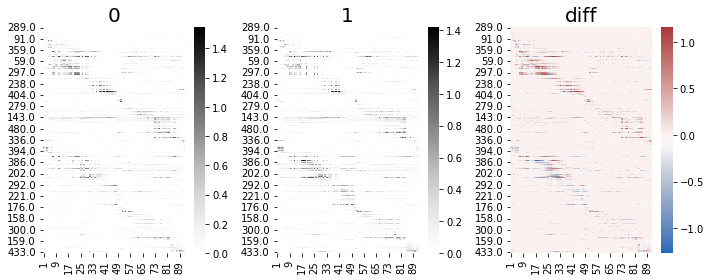

In [448]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
for ii,fac in enumerate(range(n_fac)):
    ax=sns.heatmap(multiple_maps.loc[fac].loc[ind_sorted_combined],cmap='Greys',ax=axs[ii])
    ax.set_title(fac)
diff = multiple_maps.loc[0].loc[ind_sorted_combined] - multiple_maps.loc[1].loc[ind_sorted_combined]
ax=sns.heatmap(diff,cmap='vlag',ax=axs[2])
ax.set_title('diff')
plt.tight_layout()

Text(0, 0.5, '0-1 corr')

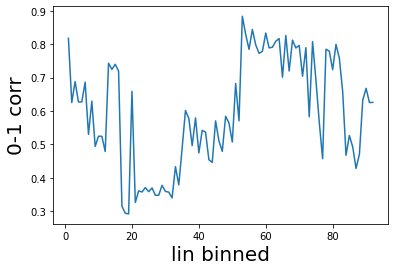

In [449]:
across_fac_corr = multiple_maps.unstack(level=0).corr().loc[(slice(None),0),(slice(None),1)]
across_fac_corr = pd.Series(np.diag(across_fac_corr),index=multiple_maps.columns)
ax=across_fac_corr.plot()
ax.set_xlabel('lin binned')
ax.set_ylabel('0-1 corr')

In [490]:
spk_beh_df_sub=spk_beh_df.loc[spk_beh_df['trial_type']==(task_ind,tt_ind)]
xilocs=dpp.index_one_tsd_using_another_t(spk_beh_df_sub,clust_label_new_combined.index)
spk_beh_df_sub['label'] = np.nan
yilocs=spk_beh_df_sub.columns.get_indexer(['label'])[0]

/tmp/ipykernel_1909607/3778873827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spk_beh_df_sub['label'] = np.nan


In [491]:
spk_beh_df_sub.iloc[xilocs,yilocs] = clust_label_new_combined['label'].values

<AxesSubplot:xlabel='Time (s)'>

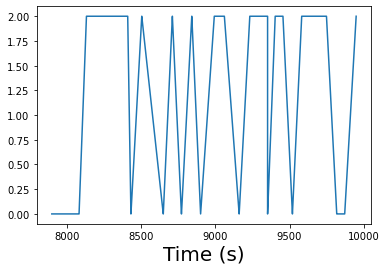

In [504]:
clust_label_new_combined.query('lin_binned==47')['label'].plot()

In [548]:
labels_s

,Time (s),0
0,7895.936767,2
1,7945.882700,1
2,7945.916033,1
3,8015.366900,1
4,8015.400267,1
...,...,...
120,9871.602433,2
121,9871.635767,2
122,9871.669100,2
123,9871.702467,2


In [549]:

spk_beh_df_sub_sub = spk_beh_df_sub.loc[spk_beh_df_sub['lin_binned']==47]

# label_s = spk_beh_df_sub_sub['label']
# labels_s=pd.Series(label_s.values)

label_s = clust_label_original[47]
labels_s=pd.Series(label_s.values)


labels_s=labels_s.reset_index()
labels_s = labels_s.sort_values([0,'index'])
X_normed = spk_beh_df_sub_sub[cell_cols].reset_index(drop=True)

In [550]:
tuning_one_pos = ca.get_cluster_tuning(multiple_maps[47].unstack().T)
ind,_,_=na.sort_factors(fitted_info.iloc[:,:-1].values)
ind=fitted_info.index[ind]

In [494]:
tuning_one_pos.loc[ind]

,tuning_0,tuning_1,tuning_2,sum_activity
36.0,-0.631573,-0.249436,-0.118992,0.383958
116.0,-0.528295,-0.530562,0.058856,0.052856
122.0,-0.931281,-0.469067,0.400347,0.212436
226.0,-0.756702,-0.706909,0.463611,0.013578
127.0,-0.708784,0.068591,-0.359807,0.082213
...,...,...,...,...
341.0,-1.000000,1.000000,-1.000000,0.002512
343.0,-1.000000,1.000000,-1.000000,0.000828
413.0,-1.000000,-1.000000,1.000000,0.000594
148.0,-0.946655,0.946655,-1.000000,0.007287


In [553]:
ind

Index([ 36, 116, 122, 226, 127, 225, 224, 129, 131, 134,
       ...
        98,  87, 175, 157,  29, 341, 343, 413, 148, 128],
      dtype='object', length=422)

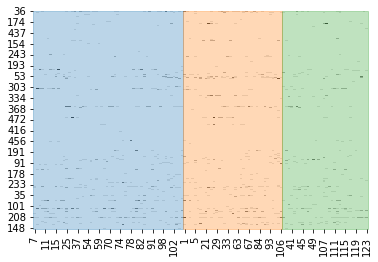

In [551]:

# plot time regrouped by cluster
time_re_ind =labels_s.index
data=X_normed.loc[time_re_ind][ind].T
fig,ax=plt.subplots()
ax=sns.heatmap(data,cmap='Greys',cbar=False,ax=ax)
fig,ax = ph.plot_shades(labels_s[0].values,ax=ax,fig=fig)

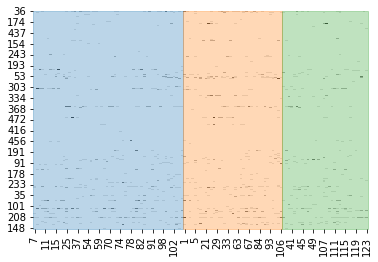

In [554]:

# plot time regrouped by cluster
time_re_ind =labels_s.index
data=X_normed.loc[time_re_ind][ind].T
fig,ax=plt.subplots()
ax=sns.heatmap(data,cmap='Greys',cbar=False,ax=ax)
fig,ax = ph.plot_shades(labels_s[0].values,ax=ax,fig=fig)

(<Figure size 576x576 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 [Int64Index([207,   1, 367, 412, 232, 413, 405, 220, 354,  31,
              ...
              359,  82, 229, 215, 189, 172, 235, 419, 267,  77],
             dtype='int64', length=422),
  Int64Index([324, 207, 281, 412, 220, 405, 413, 367, 232,   1,
              ...
               90, 167, 138,  27,  18, 209, 370, 277, 228, 218],
             dtype='int64', length=422)])

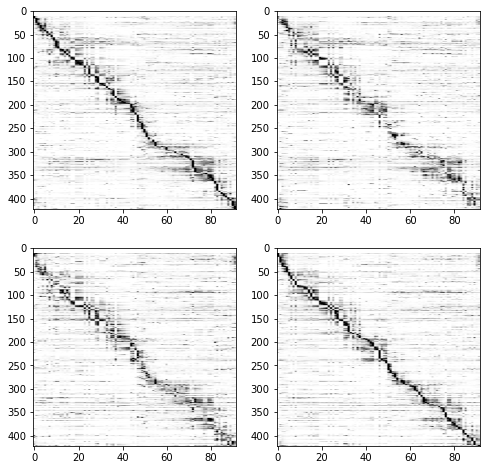

In [179]:
%matplotlib inline
import plot_ratemap_sequence as prs
fr_map_l = [multiple_maps.loc[0],multiple_maps.loc[1]]
prs.plot_multi_sequences_multi_orders(fr_map_l,order_l=None,fig=None,axs=None,normalize=True,reduce=False,vmax=None)



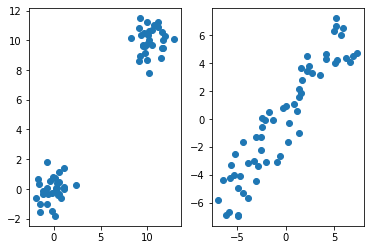

In [271]:
# simulated data; demonstrate null generation
%matplotlib inline
a = np.random.normal(size=(30,2))
b = np.random.normal(size=(30,2)) + 10
# c = np.random.normal(size=(30,2)) + 6
X_normed = np.concatenate([a,b],axis=0)
# X_normed = np.concatenate([a,b,c],axis=0)
fig,axs=plt.subplots(1,2)
axs[0].scatter(X_normed[:,0],X_normed[:,1])
X_normed = pd.DataFrame(X_normed)

X_normed_null=ca.sample_null(X_normed,n_repeats=10)

X_normed_null[0]
axs[1].scatter(X_normed_null[0][:,0],X_normed_null[0][:,1])

In [14]:
111/2.2

50.45454545454545

In [371]:
# spk_beh_df_sub = spk_beh_df.query('lin_binned==11')
# spk_beh_df_sub = spk_beh_df.query('(lin_binned==47)&(visitedArm==0)')
# spk_beh_df_sub = spk_beh_df.query('(lin_binned==47)&(visitedArm==1)')
spk_beh_df_sub = spk_beh_df.query('(lin_binned==47)&(visitedArm==1)&(v>=1)')
# spk_beh_df_sub = spk_beh_df.query('(lin_binned==24)&(visitedArm==0)&(v>=1)')

X=spk_beh_df_sub[cell_cols]


X_normed = X.astype('float') / (np.linalg.norm(X,axis=1,keepdims=True)) # each vector normalized to norm=1
X_normed = X_normed.dropna(axis=0)

X_normed = X_normed.reset_index(drop=True)

<AxesSubplot:xlabel='Time (s)'>

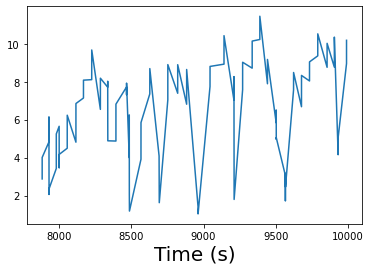

In [61]:
%matplotlib inline
spk_beh_df_sub['v'].plot()

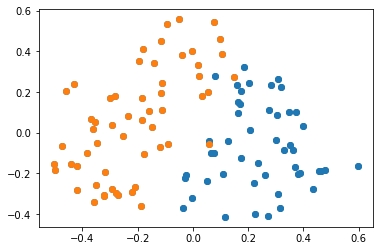

In [372]:
%matplotlib inline
n_clust = 2#3#2
kmeans=KMeans(n_clusters=n_clust).fit(X_normed)
labels=kmeans.labels_

pca = PCA(n_components=2).fit(X_normed)
H = pca.transform(X_normed)
plt.scatter(H[:,0],H[:,1])
for i in range(n_clust):
    plt.scatter(H[labels==i,0],H[labels==i,1],color=f'C{i}')



In [373]:
%%time
n_repeats = 30#30#100
X_normed_ = X_normed
# X_normed_null = [X_normed.sample(X_normed.shape[0],replace=True) for _ in range(n_repeats)]
X_normed_null = ca.sample_null(X_normed_,n_repeats=n_repeats)
n_clusters_l=np.arange(5)+1#np.arange(0,22,1)+1
k_hat,test_stats, gap_k, w_k_l, w_null_k_b_l,s_k = ca.get_gap_stat(X_normed_null,X_normed_,n_clusters_l=n_clusters_l)



CPU times: user 4min 28s, sys: 1min 11s, total: 5min 40s
Wall time: 1min 25s


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='num. clusters', ylabel='gap stats'>,
 <AxesSubplot:ylabel='difference'>)

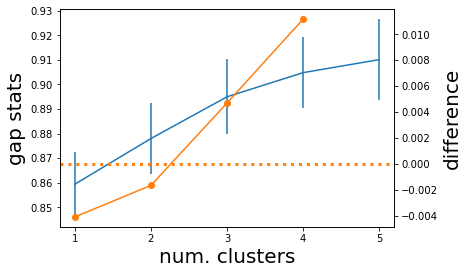

In [374]:

reload(cp)
cp.plot_gap_test(n_clusters_l,gap_k, s_k, test_stats,fig=None,ax=None)

# after selecting and fitting the kmeans, evaluation

## fitting and post processing

In [375]:
reload(ca)
n_clust = k_hat#2##3#
res = ca.cluster_and_sort(X_normed,n_clust)


uid_sorted = res['uid_sorted']
fitted_mean = res['fitted_mean']
fitted_info = res['fitted_info']                 
labels = res['labels']
labels_sorted = res['labels_sorted']





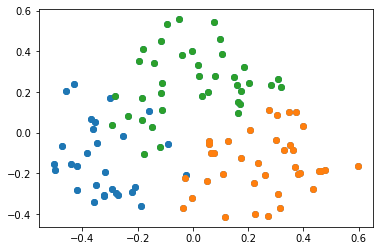

In [376]:
%matplotlib inline
pca = PCA(n_components=2).fit(X_normed)
H = pca.transform(X_normed)
plt.scatter(H[:,0],H[:,1])
for i in range(n_clust):
    plt.scatter(H[labels==i,0],H[labels==i,1],color=f'C{i}')



In [352]:
spk_beh_df_sub['labels']=labels

/tmp/ipykernel_1909607/3353129577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spk_beh_df_sub['labels']=labels


In [366]:
spk_beh_df_sub.groupby('labels')['speed_kalman','visitedArm'].mean()

/tmp/ipykernel_1909607/2616133913.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  spk_beh_df_sub.groupby('labels')['speed_kalman','visitedArm'].mean()


,speed_kalman,visitedArm
labels,,
0,14.506836,0.52000
1,13.644729,0.50000
2,13.467035,0.53125


<IPython.core.display.Javascript object>


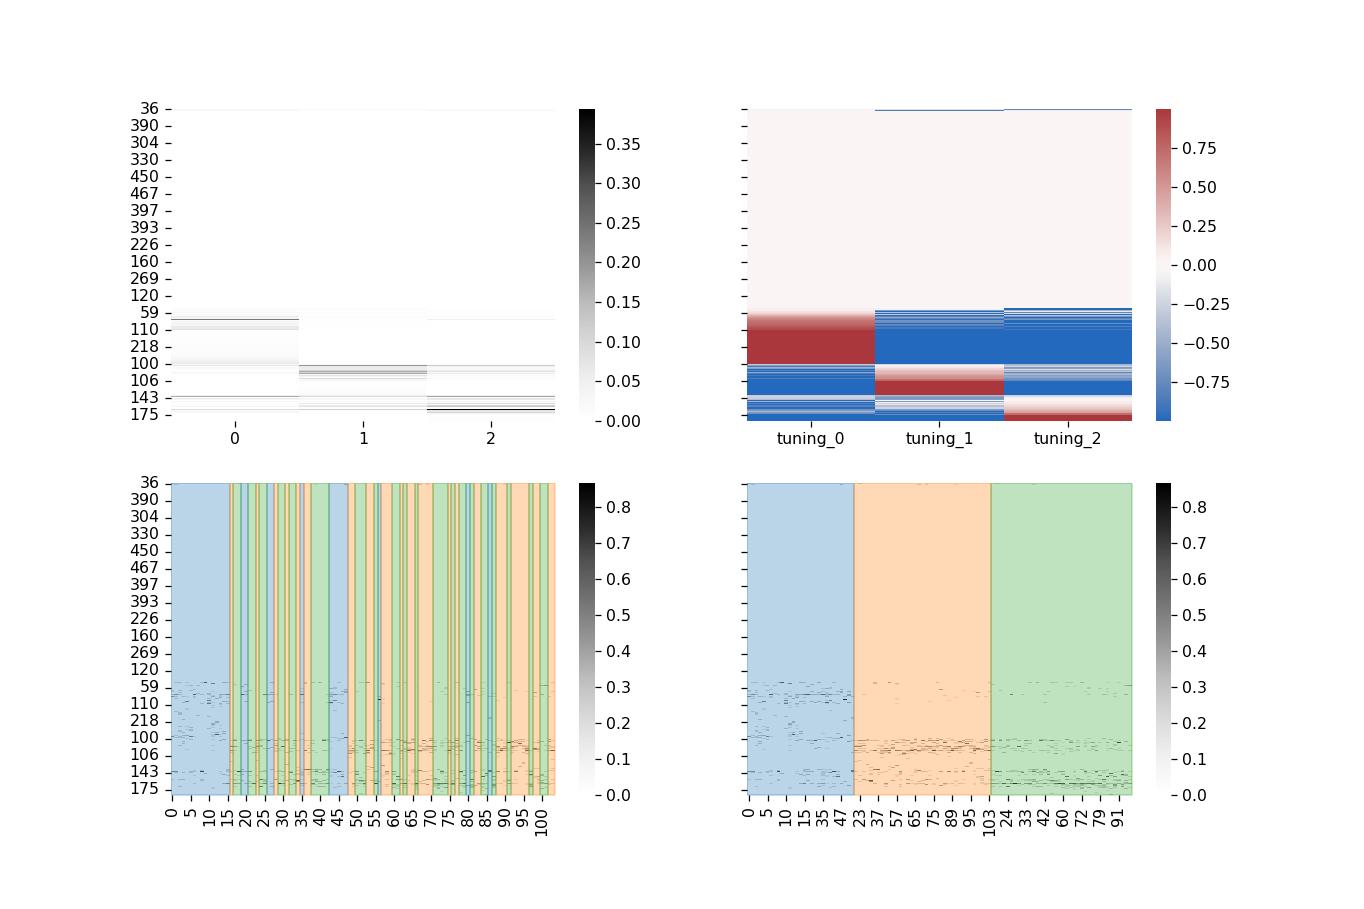

(<Figure size 864x576 with 8 Axes>, <AxesSubplot:>)

In [377]:
# plots!
%matplotlib notebook
# fitted mean, fitted tuning, data original, data time grouped
nplots = 4
fig,axs=ph.subplots_wrapper(nplots,sharey=True)
axs = axs.ravel()
ax=axs[0]
sns.heatmap(fitted_mean,cmap='Greys',ax=ax)
ax=axs[1]
sns.heatmap(fitted_info.iloc[:,:-1],cmap='vlag',ax=ax)
ax=axs[2]
sns.heatmap(X_normed.T.loc[uid_sorted],cmap='Greys',ax=ax)
ph.plot_shades(labels,fig=fig,ax=ax)
ax=axs[3]
sns.heatmap(X_normed.T.loc[uid_sorted,labels_sorted.index],cmap='Greys',ax=ax)
ph.plot_shades(labels_sorted['label'].values,fig=fig,ax=ax)

    

In [93]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

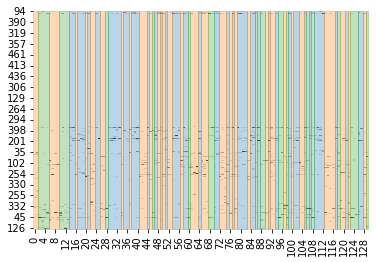

In [229]:
import nmf_analysis as na
# fitted_info_sorted = na.hierarchical_sort(fitted_info,to_cut_nbins=[4],to_cut_keys=['cluster_tuning'],final_sort_key='sum_activity')
# fitted_info_sorted = na.hierarchical_sort(fitted_info,to_cut_nbins=[4,4,4],to_cut_keys=['tuning_0','tuning_1','tuning_2'],final_sort_key='sum_activity',ascending=False)
# ind = fitted_info_sorted.index

ind,_,_=na.sort_factors(fitted_info.iloc[:,:3].values)
ind=fitted_info.index[ind]

# ind,_,_=na.sort_factors(fitted_mean.iloc[:,:3].values)
# ind=fitted_mean.index[ind]



# fig,axs=plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[0.1,1]})
# axs[0].plot(labels)
fig,ax=plt.subplots()
ax=sns.heatmap(X_normed[ind].T,cmap='Greys',cbar=False,ax=ax)
fig,ax = ph.plot_shades(labels,ax=ax,fig=fig)


In [213]:
labels_s=pd.Series(labels)

labels_s=labels_s.reset_index()

labels_s = labels_s.sort_values([0,'index'])

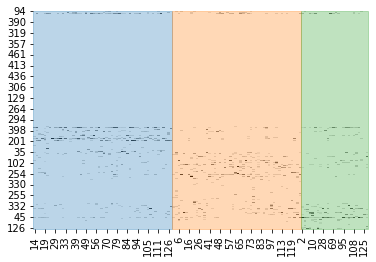

In [230]:
# plot time regrouped by cluster
time_re_ind =labels_s.index
data=X_normed.loc[time_re_ind][ind].T
fig,ax=plt.subplots()
ax=sns.heatmap(data,cmap='Greys',cbar=False,ax=ax)
fig,ax = ph.plot_shades(labels_s[0].values,ax=ax,fig=fig)

In [145]:
fitted_info

,tuning_0,tuning_1,tuning_2,sum_activity
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
27,-0.006712,-0.540871,-0.452418,0.350876
29,-0.497335,-1.000000,0.497335,0.064068
...,...,...,...,...
476,0.000000,0.000000,0.000000,0.000000
477,0.000000,0.000000,0.000000,0.000000
478,0.000000,0.000000,0.000000,0.000000
479,-1.000000,1.000000,-1.000000,0.013215


In [139]:
fitted_info_sorted

,tuning_0,tuning_1,tuning_2,sum_activity,tuning_0_binned,tuning_1_binned,tuning_2_binned
312,0.577642,-0.733821,-0.843821,0.262017,3,0,0
140,0.605765,-0.802630,-0.803135,0.166469,3,0,0
379,0.815029,-0.895169,-0.919860,0.164614,3,0,0
385,0.798667,-1.000000,-0.798667,0.105967,3,0,0
57,1.000000,-1.000000,-1.000000,0.067057,3,0,0
...,...,...,...,...,...,...,...
143,-0.617061,-0.854709,0.471770,0.228587,0,0,2
53,-0.682969,-0.775281,0.458250,0.170329,0,0,2
52,-0.563970,-0.526006,0.089976,0.077888,0,0,2
110,-0.660163,-0.767194,0.427356,0.036631,0,0,2


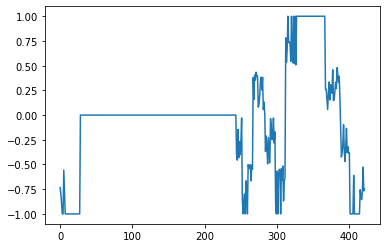

In [144]:
plt.plot(fitted_info_sorted['tuning_1'].values)

In [287]:
labels[18:24]

array([0, 0, 1, 1, 0, 1], dtype=int32)

In [ ]:
#### xs = np.arange(len(labels))
xs = np.append(xs-0.5,xs[-1]+0.5)
xs_2d = np.stack([xs[:-1],xs[1:]],axis=1)

In [261]:
true_segments = labels == 0
xs_2d_with_label = pd.Series(np.tile(true_segments,(2,)),index=xs_2d.flatten(order='F'))

In [270]:
xs_2d_with_label.loc[0.5]

0.5    True
0.5    True
dtype: bool

In [317]:
def plot_shades(labels,fig=None,ax=None):
    if ax is None:
        fig,ax=plt.subplots()
#     xs = np.arange(len(labels))
#     xs = np.append(xs-0.5,xs[-1]+0.5)
#     xs = np.append(xs,xs[-1]+1)
#     xs_2d = np.stack([xs[:-1],xs[1:]],axis=1) # expand into edges
    clust_l = np.unique(labels)
    labels_extended = np.insert(labels,0,-1)
    labels_extended = np.append(labels_extended,-1)
    for ii,c in enumerate(clust_l):
        true_segments = labels_extended == c
        true_segments_diff = np.diff(true_segments.astype(int))
        seg_starts=np.nonzero(true_segments_diff==1)[0] 
        seg_ends = np.nonzero(true_segments_diff==-1)[0] 
        for (st,ed) in zip(seg_starts,seg_ends):
            ax.fill_between(np.array([st,ed]),0,1,color=f'C{ii}', alpha=0.3, transform=ax.get_xaxis_transform())
        
#         xs_2d_with_label = pd.Series(np.tile(true_segments,(2,)),index=xs_2d.flatten(order='F'))
#         edges_mask=xs_2d_with_label = xs_2d_with_label.groupby(level=0).any()
#         ax.fill_between(xs, 0, 1, where=(edges_mask.values),
#         color=f'C{ii}', alpha=0.3, transform=ax.get_xaxis_transform())
    return fig,ax
    

In [309]:
labels

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0], dtype=int32)

(0.0, 12.0)

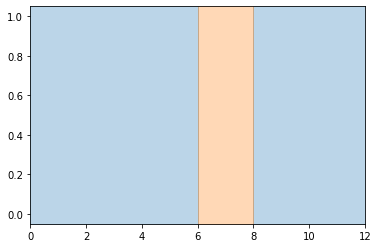

In [319]:
fig,ax=plot_shades(labels,fig=None,ax=None)
# ax.set_xlim([0,12])

In [241]:
labels

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0], dtype=int32)

In [145]:
# from matplotlib.ticker import FormatStrFormatter

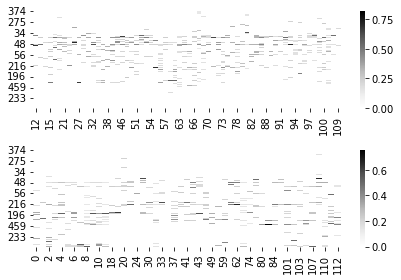

In [169]:
n_clust = fitted_mean.shape[0]
fig,axs = plt.subplots(n_clust)
for i in range(n_clust):
#     selected_time = (i==kmeans.labels_)
    selected_time = (i==bgm_labels)
    if selected_time.sum()>0:
        ax=axs[i]
        sns.heatmap(X_normed.loc[selected_time,ind].T ,ax=ax,cmap='Greys')
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#         ax.set_xlabel('')
plt.tight_layout()

In [173]:
labels = kmeans.labels_

In [175]:
spk_beh_df_sub['labels'] = labels

/tmp/ipykernel_1270487/236960208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spk_beh_df_sub['labels'] = labels


(115,)

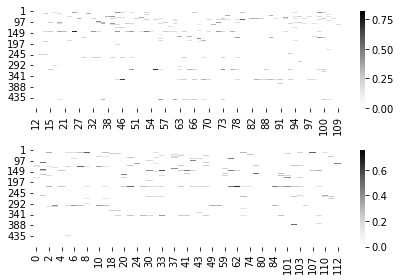

In [157]:
n_clust = fitted_mean.shape[0]
fig,axs = plt.subplots(n_clust)
for i in range(n_clust):
    selected_time = (i==kmeans.labels_)
#     selected_time = (i==bgm_labels)
    if selected_time.sum()>0:
        ax=axs[i]
        sns.heatmap(X_normed.loc[selected_time].T ,ax=ax,cmap='Greys')
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#         ax.set_xlabel('')
plt.tight_layout()

<AxesSubplot:xlabel='Time (s)'>

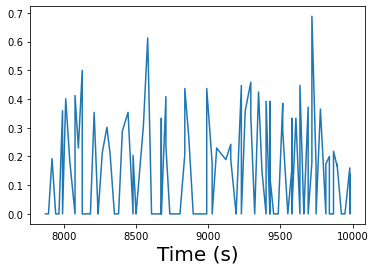

In [127]:
X[27].plot()

In [112]:
bgm.predict_proba(X_normed)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [91]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0], dtype=int32)